In [1]:
''' This project is about London hous price prediction. The house price data is loaded, cleaned, and then 
    several predictive models were built. The house price prediction is made using the best model'''

__author__ = 'Sakiru Badmos'
__email__ = 'babs4sure86@gmail.com'

**Import the required libraries**


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle as pkl

plt.style.use('ggplot')
%matplotlib inline

**Define helper functions**

In [3]:
def load_data(file):
    '''loads csv file into a pandas dataframe'''
    return pd.read_csv(file)

def categorize_features(df):
    global num_var, cat_var, cat_num_var
    num_var = [col for col in df.columns if df[col].dtype != 'O' 
               and df[col].nunique() > 13 and col not in ['id','price']]
    cat_var = [col for col in df.columns if df[col].dtype == 'O']
    cat_num_var = [col for col in df.columns if df[col].dtype != 'O'
                   and df[col].nunique() <= 13  and col not in ['id','price']]
   # return num_var, cat_var, cat_num_var
    
def fill_missing_cat_num_var(df, cat_num_var):
    for var in cat_num_var:
        if df[var].isnull().sum()>0:
            if var != 'n_bedrooms':
                mode = df[var].mode()[0]
                df[var].fillna(mode, inplace= True)
            else:
                if df['property_type'].any() == 'studio':
                    df[var].fillna(0, inplace= True)
                else:
                    mode= df[var].mode()[0]
                    df[var].fillna(mode, inplace= True)

def fill_missing_num_var(df, num_var):
    for var in num_var:
        if df[var].isnull().sum() > 0:
            mode = df[var].mode()[0]
            df[var].fillna(mode, inplace = True)

def fill_missing_cat_var(df, cat_var):
    cat_var_with_missing_val = [col for col in cat_var if df[col].isnull().sum() > 0]
    for var in cat_var_with_missing_val:
        df[var].fillna('missing', inplace = True)

def bin_col_values(df, col):
    df[col] = df[col].apply(lambda x: x[:2] if len(x) == 6 else x[:3])
    print(df[col].head())
    print(f'The {col} column now has {df[col].nunique()} categories' )

def count_unique(df, var_list):
    for var in var_list:
        print(f'({var}) contains {house_data[var].nunique()} unique values')
        print(f'The labels in {var} are:')
        print(house_data[var].value_counts(normalize = True))
        print('--------------------------------------------------------')
        
def visualize_cat_features(df, cat_var):
    for var in cat_var:
        if var not in ['agent_name', 'postcode']:
            df.groupby(var)['price'].mean().plot(kind = 'bar')
            plt.xlabel(var)
            plt.ylabel('Mean Price')
            plt.show()
        
def explore_n_bedrooms(df):
    for category in list(df['n_bedrooms'].dropna().unique()):
        df[df['n_bedrooms'] == category].groupby('property_type')['price'].mean().plot(kind = 'bar')
        plt.xlabel('Property type')
        plt.ylabel('Mean Price')
        plt.title(f'Mean house price for {category} bedrooms')
        plt.show()
    

def visualize_num_features(df, num_var):
    for col in num_var:
        plt.hist(df[col], bins= 20)
        plt.xlabel(col)
        plt.ylabel('Number of houses')
        plt.show()
    
def visualize_transformed_num_var(df, num_var):
    for var in num_var:
        skewed_var = house_data[num_var].apply(lambda x: stats.skew(x.dropna()))
        skewed_var = skewed_var[skewed_var > 0.75]      # skewed if skewness > 0.75
        skewed_var = skewed_var.index
    for var in skewed_var:
        df[var]= np.log1p(df[var])
        df[var].hist(bins = 20)
        plt.xlabel(var)
        plt.ylabel('number of houses')
        plt.title(var)
        plt.show()
    
def visualize_cat_num_var(df, cat_num_var):
    for var in cat_num_var:
        house_data.groupby(var)['price'].mean().plot(kind = 'bar')
        plt.xlabel(var)
        plt.ylabel('Price')
        plt.show()
        
def get_info(df):
    dimension = df.shape
    print(f'The data contains {dimension[0]} records and {dimension[1]} columns\n')
    
    print('Viewing the columns in the data...\n')
    print(df.columns)
    
def get_more_info(df):
    
    print('Data types and number of non-null records in each column: \n')
    print(f'{df.info()}\n')
    
    print('The number of unique values in each column:\n')

    print(f'{df.nunique()}\n')
  #  print('\n************************************')
    print('Checking for duplicate records \n')
    n_duplicates = df.duplicated().sum()
    print(f'The data contains {n_duplicates} duplicates')
    
def check_missing_val(df, col):
    return df[col].isnull().sum()*100/len(df)

def check_null_in_property(df, col):
    print(df.loc[df[col].isnull(), 'property_type'].value_counts())
    
def plot_corr(df):
    plt.figure(figsize= (15,10))
    sns.heatmap(df.corr('spearman'), annot= True, linewidths= 0.15)
    plt.show()
    
def plot_scatter(df, num_var):
    for var in num_var:
        plt.scatter(house_data[var], house_data['price'] )
        plt.xlabel(var)
        plt.ylabel('Price')
        plt.show()
    
def plot_scatter_log(df, num_var):
    for var in num_var:
        plt.scatter(house_data[var], np.log1p(house_data['price']) )
        plt.xlabel(var)
        plt.ylabel('Price')
        plt.show()
    
def visualize_target(df, target):
    plt.figure(figsize = (14,6))
    plt.subplot(1,2,1)
    sns.boxplot(df[target])
    plt.subplot(1,2,2)
    sns.distplot(df[target], bins= 20)
    
def detect_outlier(df):
    global lower, upper
    Q1, Q3 = np.percentile(df['price'], [25, 75])
    IQR = Q3 - Q1
    upper = Q3 + 1.5*IQR
    lower = Q1 - 1.5*IQR
    print(f'The upper and lower bounds for suspected outliers are {upper} and {lower} ')
    
def remove_oulier(df):
    global df2
    df2 = df.loc[ (df['price'] <= upper) & (df['price'] >= lower) , :]
    return df2

def drop_column(df, columns):
    df.drop(columns=columns, inplace= True)
    
def encode_feature(df):
    return pd.get_dummies(df, drop_first= True)
    

In [83]:
def get_target(df, target):
    return df[target]

def model_trainer(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    cv = KFold(n_splits= 8, random_state= 42, shuffle= True )
    mse_neg = cross_val_score(model, feature_df, target_df, cv=cv, n_jobs= num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = np.sqrt(np.mean(-1.0*mse_neg))
    cv_std[model] = np.std(mse_neg)
    
def model_trainer_cv(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    model.fit(feature_df, target_df)
    model = model.best_estimator_
    cv = KFold(n_splits= 8, random_state= 42, shuffle= True )
    mse_neg = cross_val_score(model, feature_df, target_df, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error')
    mean_mse[model] = np.sqrt(np.mean(-1.0*mse_neg))
    cv_std[model] = np.std(mse_neg)

def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

def save_results(model, mean_mse, predictions, feature_importances):
    '''saves model, model summary, feature importances, and predictions'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
        feature_importances.to_csv('feature_importances.csv') 
        np.savetxt('predictions.csv', predictions, delimiter=',')
        
def plot_feature_importance(model):
    fig, [ax1,ax2, ax3, ax4, ax5] = plt.subplots(5,1, figsize=(8,15))
    model_1_FI = pd.Series(model[0].best_estimator_.feature_importances_, index=X_train.columns).head(10).sort_values()
    model_2_FI = pd.Series(model[1].best_estimator_.feature_importances_, index=X_train.columns).head(10).sort_values()
    model_3_FI = pd.Series(model[2].best_estimator_.feature_importances_, index=X_train.columns).head(10).sort_values()
    model_4_FI = pd.Series(model[3].best_estimator_.feature_importances_, index=X_train.columns).head(10).sort_values()
    model_5_FI = pd.Series(model[4].best_estimator_.feature_importances_, index=X_train.columns).head(10).sort_values()
    ax1.barh(model_1_FI.index, model_1_FI.values, color='red')
    ax2.barh(model_2_FI.index, model_2_FI.values, color='blue')
    ax3.barh(model_3_FI.index, model_3_FI.values, color='green')
    ax4.barh(model_4_FI.index, model_4_FI.values, color='purple')
    ax5.barh(model_5_FI.index, model_5_FI.values, color='pink')
    ax1.set_title(' Random Forest Feature Importances')
    ax1.set_xlabel('Importances')
    ax1.set_ylabel('Features')
    ax2.set_title('Gradient Boosting Feature Importances')
    ax2.set_xlabel('Importances')
    ax2.set_ylabel('Features')
    ax3.set_title('Stochastic Gradient Boosting Feature Importances')
    ax3.set_xlabel('Importances')
    ax3.set_ylabel('Features')
    ax4.set_title('LightGBM Feature Importances')
    ax4.set_xlabel('Importances')
    ax4.set_ylabel('Features')
    ax5.set_title('XGBoost Feature Importances')
    ax5.set_xlabel('Importances')
    ax5.set_ylabel('Features')
    plt.tight_layout()
    

In [75]:
[grid_search_rf, grid_search_gbr, grid_search_sgbr, grid_search_lgb, grid_search_xgb]

10

In [5]:
# Load data
print('Loading data...')
house_data = load_data('zoopla.csv')
print('Done')

Loading data...
Done


In [6]:
house_data.head(3)

,id,agent_name,condition,distance_to_charing_cross,distance_to_closest_airport,distance_to_closest_dlr_or_underground_station,distance_to_closest_national_rail_station,distance_to_closest_primary_school,latitude,longitude,n_bathrooms,n_bedrooms,n_reception_rooms,postcode,price,price_qualifier,property_type,size_sqft,status,tenure
0,893588,Hamptons International,pre-owned,2.043523,10.497350,0.177325,0.351489,0.260448,51.510722,-0.095667,2.0,2.0,1.0,EC4V 3EJ,1050000,NaN,flat,NaN,for_sale,leasehold
1,939056,Hamptons International,pre-owned,2.305455,10.202792,0.504113,0.411439,0.407471,51.506942,-0.091646,4.0,3.0,1.0,SE1 9DW,3950000,NaN,flat,NaN,for_sale,leasehold
2,1686433,Jorgensen Turner,pre-owned,7.224687,16.511607,0.363300,0.852112,0.243911,51.508411,-0.228859,NaN,3.0,NaN,W12 7EY,780000,NaN,flat,NaN,for_sale,freehold


## Data Cleaning and EDA

In [7]:
get_info(house_data)

The data contains 36213 records and 20 columns

Viewing the columns in the data...

Index(['id', 'agent_name', 'condition', 'distance_to_charing_cross',
       'distance_to_closest_airport',
       'distance_to_closest_dlr_or_underground_station',
       'distance_to_closest_national_rail_station',
       'distance_to_closest_primary_school', 'latitude', 'longitude',
       'n_bathrooms', 'n_bedrooms', 'n_reception_rooms', 'postcode', 'price',
       'price_qualifier', 'property_type', 'size_sqft', 'status', 'tenure'],
      dtype='object')


In [8]:
get_more_info(house_data)

Data types and number of non-null records in each column: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36213 entries, 0 to 36212
Data columns (total 20 columns):
id                                                36213 non-null int64
agent_name                                        36213 non-null object
condition                                         36213 non-null object
distance_to_charing_cross                         36213 non-null float64
distance_to_closest_airport                       36213 non-null float64
distance_to_closest_dlr_or_underground_station    33857 non-null float64
distance_to_closest_national_rail_station         34756 non-null float64
distance_to_closest_primary_school                36213 non-null float64
latitude                                          36213 non-null float64
longitude                                         36213 non-null float64
n_bathrooms                                       31812 non-null float64
n_bedrooms                      

In [9]:
categorize_features(house_data)

In [10]:
cat_var

['agent_name',
 'condition',
 'postcode',
 'price_qualifier',
 'property_type',
 'status',
 'tenure']

## Categorical variables

The number of unique values in each categorical variable can be used to gain insight into the variables

In [11]:
count_unique(house_data, cat_var)

(agent_name) contains 1642 unique values
The labels in agent_name are:
Foxtons                              0.068953
Dexters                              0.042830
Purplebricks                         0.031066
Chestertons                          0.023748
Winkworth                            0.021070
Hamptons International               0.019661
Marsh & Parsons                      0.017701
Barnard Marcus                       0.015795
MyLondonHome                         0.012730
JLL                                  0.012703
John D Wood & Co                     0.010880
Johns & Co                           0.010052
Douglas & Gordon                     0.009444
Chase Evans                          0.009251
Bairstow Eves Countrywide            0.008809
Hunters                              0.008395
Property Inside London               0.007981
Hastings International               0.007373
Jacksons Estate Agents               0.006683
Kinleigh Folkard & Hayward           0.006655
Ellis & C

Some points to note about the categorical variables
* The __agents__ contains over __1500__ categories
* The __postcode__ feature contains over __18000__ categories. It needs to be engineered by binning
* There are __three__ labels in status with one of the labels having __99.99%__ of the total number. This will most likely __not contribute__ to the model
* The condition feature has __two__ categories with pre-owed apartment dominating the feature
* The property_type feature contains __10__ categories representing the types of apartment considered

The variation of the mean price with the categories can be investigated by plotting the mean price for each category for each categorical feature excluding the agaent name and postcode

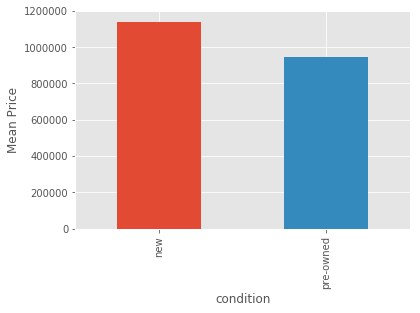

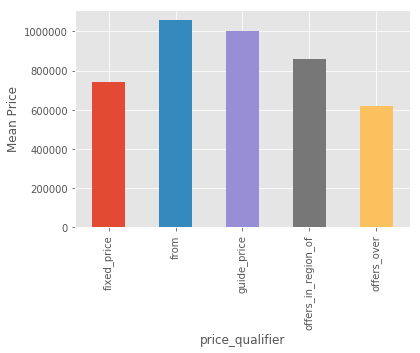

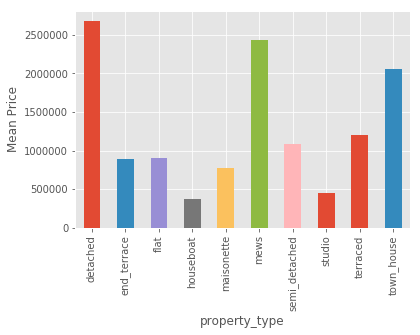

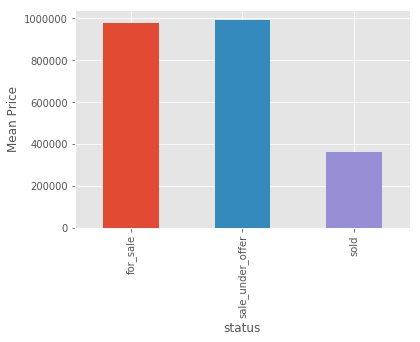

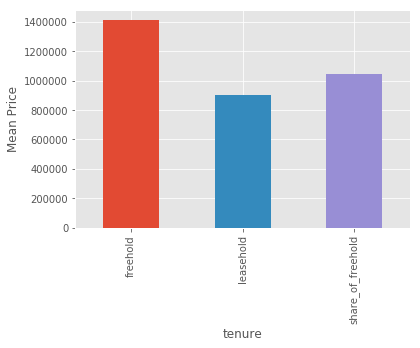

In [12]:
visualize_cat_features(house_data, cat_var)

The plots above revealed the following:
* Pre-owned houses are cheaper than new homes based on the mean price across all properties.
* Detached houses seem to be the most expensive based on the mean price. However, no conclusion can be made now as the house price needs to be explored based on the number of rooms as well.
* Houses with label 'sold' tends to have lower price compared to 'under offer' and 'for sale' ones.

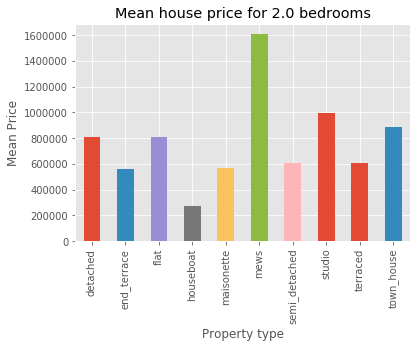

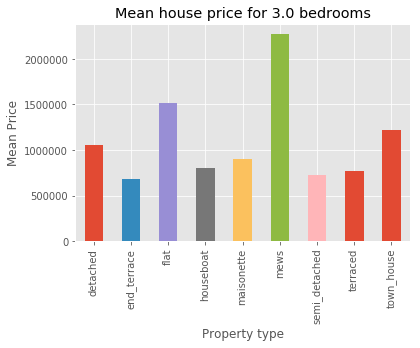

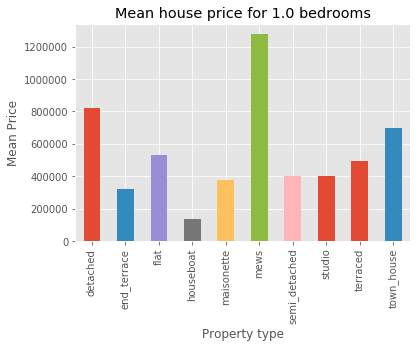

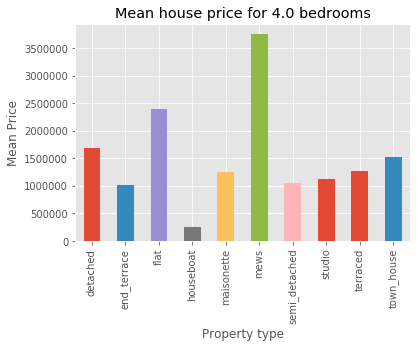

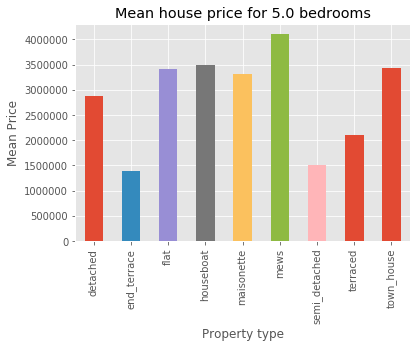

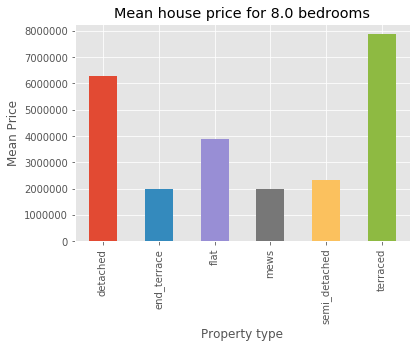

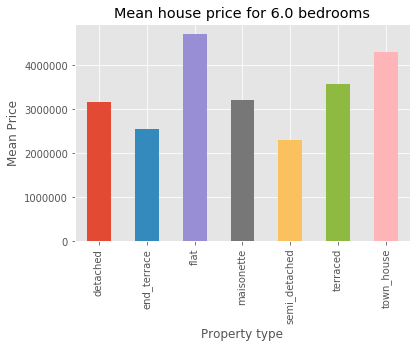

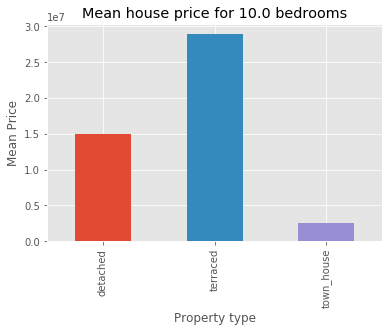

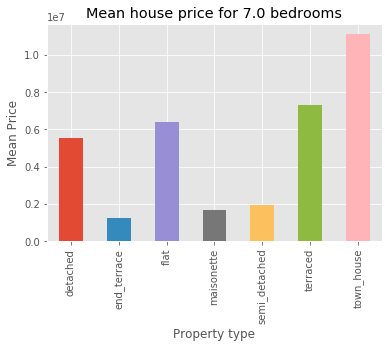

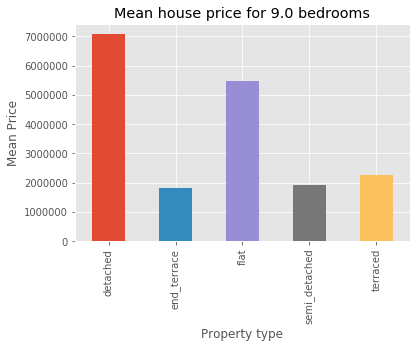

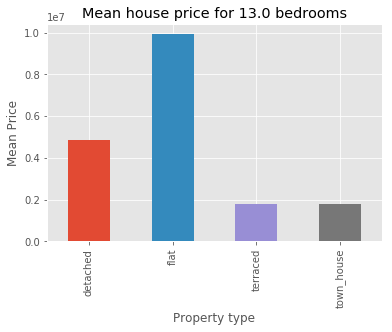

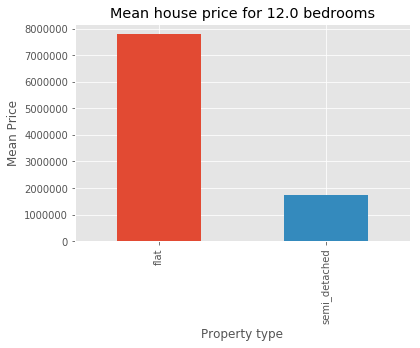

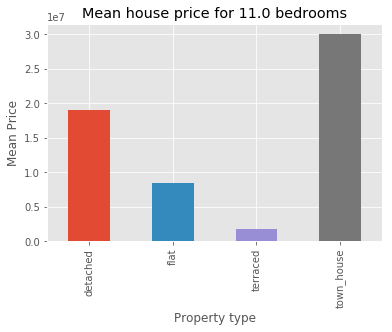

In [13]:
explore_n_bedrooms(house_data)

* Mews houses with __1-5 bedrooms__ tend to be the most expensive.
* For houses with __more than 5 bedrooms__, the highest mean price tends to vary with the number of bedrooms. This implies that __other factors are at play__ in determining the highest price
* Only __two__ types of properties have __12__ bedrooms

**Feature Engineering (Binning the postcode variable)**

The postcode variable has entries with 6 - 8 characters. They can be binned into groups based on the area/district codes i.e the first part of the postcode. Doing this will reduce the number of cartegories.

In [14]:
bin_col_values(house_data, 'postcode')

0    EC4
1    SE1
2    W12
3    E14
4    E17
Name: postcode, dtype: object
The postcode column now has 100 categories


Now, the number of unique categories has been reduced to 100. For agent_name however, it cannot be binned and will be dropped.

In [15]:
house_data.drop(columns= 'agent_name', inplace=True)
cat_var.remove('agent_name')
cat_var

['condition',
 'postcode',
 'price_qualifier',
 'property_type',
 'status',
 'tenure']

**Checking for missing values**

In [16]:
check_missing_val(house_data, cat_var)

condition           0.000000
postcode            0.000000
price_qualifier    78.720349
property_type       0.000000
status              0.000000
tenure             40.225886
dtype: float64

price_qualifier has about 79% missing records and tenure about 40%. The missing entries can be replaced with the word 'missing'

In [17]:
fill_missing_cat_var(house_data, cat_var)

In [18]:
check_missing_val(house_data, cat_var)

condition          0.0
postcode           0.0
price_qualifier    0.0
property_type      0.0
status             0.0
tenure             0.0
dtype: float64

## Numerical Categorical variables

In [19]:
count_unique(house_data, cat_num_var)

(n_bathrooms) contains 12 unique values
The labels in n_bathrooms are:
1.0     0.565541
2.0     0.343047
3.0     0.064535
4.0     0.016095
5.0     0.006758
6.0     0.002515
7.0     0.000849
8.0     0.000251
10.0    0.000220
9.0     0.000126
13.0    0.000031
12.0    0.000031
Name: n_bathrooms, dtype: float64
--------------------------------------------------------
(n_bedrooms) contains 13 unique values
The labels in n_bedrooms are:
2.0     0.407226
1.0     0.237195
3.0     0.223224
4.0     0.079390
5.0     0.034728
6.0     0.011939
7.0     0.003493
8.0     0.001575
9.0     0.000630
13.0    0.000200
10.0    0.000200
11.0    0.000143
12.0    0.000057
Name: n_bedrooms, dtype: float64
--------------------------------------------------------
(n_reception_rooms) contains 8 unique values
The labels in n_reception_rooms are:
1.0     0.834827
2.0     0.131180
3.0     0.024650
4.0     0.006792
5.0     0.001931
6.0     0.000345
7.0     0.000241
11.0    0.000034
Name: n_reception_rooms, dtype: floa

All the categorical numerical features have some levels with very low number of occurrences. These levels can be grouped as a single level

**Visualize categorical numerical features**

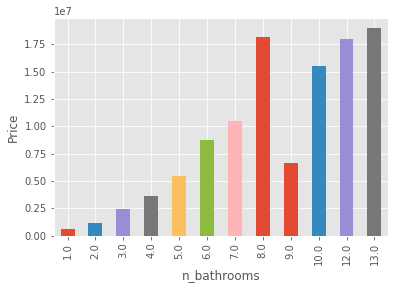

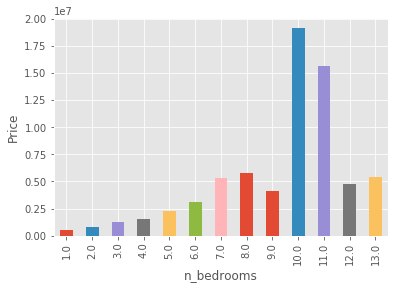

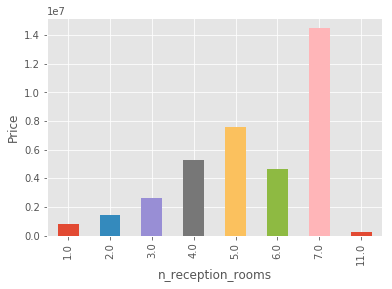

In [20]:
visualize_cat_num_var(house_data, cat_num_var)

The mean price in general increases with number of bathrooms, number of bedrooms and number of reception rooms.

**Handling null values**

In [21]:
check_missing_val(house_data, cat_num_var)

n_bathrooms          12.153094
n_bedrooms            3.545688
n_reception_rooms    19.901693
dtype: float64

There are some missing values for number of bedrooms, number of bathrooms and number of receptions.
* It is very unlikely for a house not to have a bedroom and a bathroom. We can further explore the type of property containing these missing number of bedrooms
* It is possible for some houses not to have reception 


In [22]:
check_null_in_property(house_data, 'n_bathrooms')

flat             3061
terraced          451
semi_detached     252
studio            165
maisonette        156
detached          141
end_terrace       109
mews               35
town_house         30
houseboat           1
Name: property_type, dtype: int64


In [23]:
check_null_in_property(house_data, 'n_bedrooms')

studio           1249
maisonette         10
terraced            9
semi_detached       7
detached            5
end_terrace         2
flat                1
mews                1
Name: property_type, dtype: int64


In [24]:
check_null_in_property(house_data, 'n_reception_rooms')

flat             5264
terraced          578
studio            348
semi_detached     330
maisonette        219
detached          188
end_terrace       147
town_house         85
mews               44
houseboat           4
Name: property_type, dtype: int64


* It can be seen that most houses with no bedrooms are studios. This make sense. The missing values for studio can be filled with zero and the rest with the mode of the corresponding category
* The missing values in bathrooms and reception rooms can be filled with the mode of the category

In [25]:
fill_missing_cat_num_var(house_data, cat_num_var)

In [26]:
check_missing_val(house_data, cat_num_var)

n_bathrooms          0.0
n_bedrooms           0.0
n_reception_rooms    0.0
dtype: float64

## Numerical variables

The numerical variables could be explored by doing some statistical analysis on them and plotting their distributions

In [27]:
house_data[num_var].describe()

,distance_to_charing_cross,distance_to_closest_airport,distance_to_closest_dlr_or_underground_station,distance_to_closest_national_rail_station,distance_to_closest_primary_school,latitude,longitude,size_sqft
count,36213.000000,36213.000000,33857.000000,34756.000000,36213.000000,36213.000000,36213.000000,6671.000000
mean,7.314231,13.101292,0.767370,0.839848,0.285789,51.513193,-0.126883,1492.280618
std,3.626001,4.754459,0.615617,0.562854,0.162778,0.049660,0.086161,17925.746187
min,0.065175,0.380171,0.008015,0.007558,0.000000,51.385575,-0.346497,1.000000
25%,4.301126,9.935384,0.338685,0.445682,0.168802,51.483481,-0.190405,615.000000
50%,6.985896,14.009981,0.577277,0.713986,0.261334,51.509601,-0.134423,837.000000
75%,10.037589,16.916483,0.991629,1.078174,0.380560,51.541348,-0.068739,1178.000000
max,19.482351,23.712697,4.790742,6.306888,7.956990,51.665626,0.137295,931939.000000


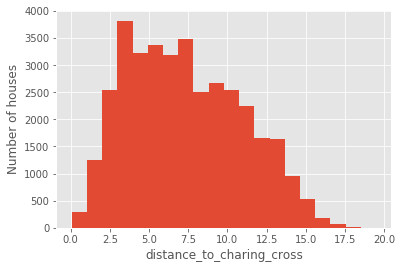

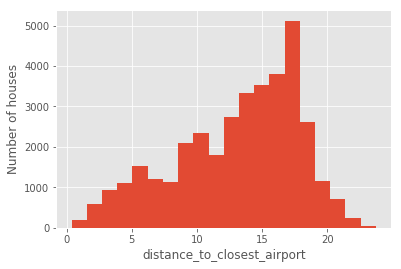

C:\Users\Sakiru\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Sakiru\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


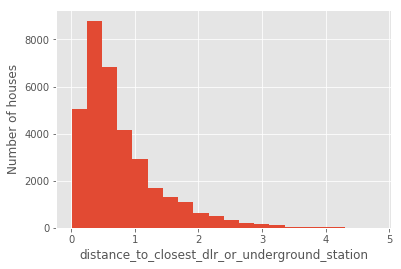

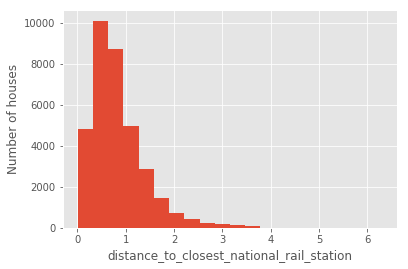

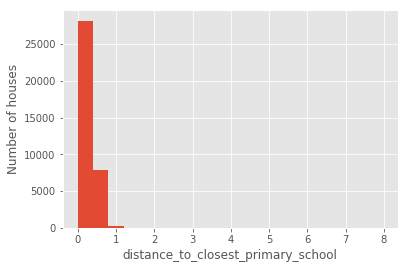

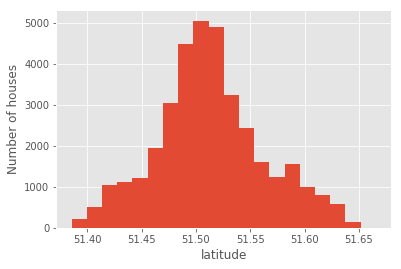

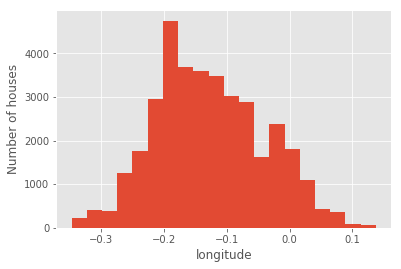

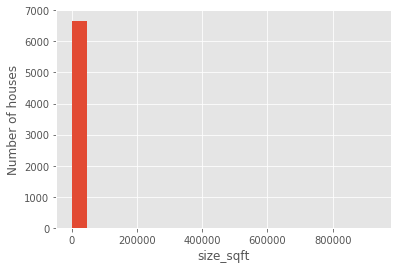

In [28]:
visualize_num_features(house_data, num_var)

Some of the numerical variables appear skewed. They can be log transformed

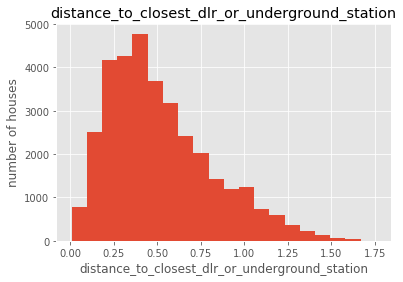

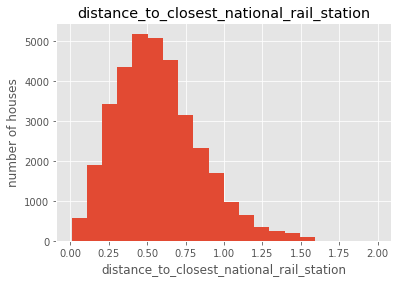

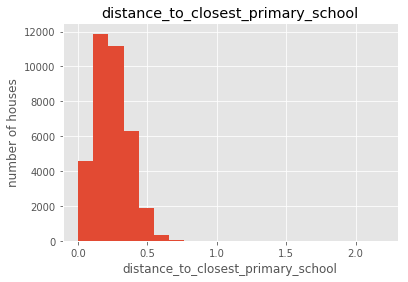

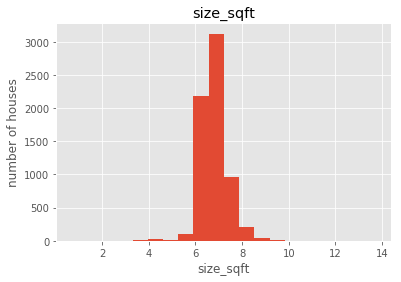

In [29]:
visualize_transformed_num_var(house_data, num_var)

The numerical variables have been log transformed and the distribution has been improved

**Handling null values**

In [30]:
check_missing_val(house_data, num_var)

distance_to_charing_cross                          0.000000
distance_to_closest_airport                        0.000000
distance_to_closest_dlr_or_underground_station     6.505951
distance_to_closest_national_rail_station          4.023417
distance_to_closest_primary_school                 0.000000
latitude                                           0.000000
longitude                                          0.000000
size_sqft                                         81.578439
dtype: float64

About 82% of size_sqft variable are missing. The variable has to be dropped since a lot of the entries are missing. The remaining two variables with missing values could be filled with the mode

In [31]:
fill_missing_num_var(house_data, num_var)

In [32]:
check_missing_val(house_data, num_var)

distance_to_charing_cross                         0.0
distance_to_closest_airport                       0.0
distance_to_closest_dlr_or_underground_station    0.0
distance_to_closest_national_rail_station         0.0
distance_to_closest_primary_school                0.0
latitude                                          0.0
longitude                                         0.0
size_sqft                                         0.0
dtype: float64

## Explore relationship with features

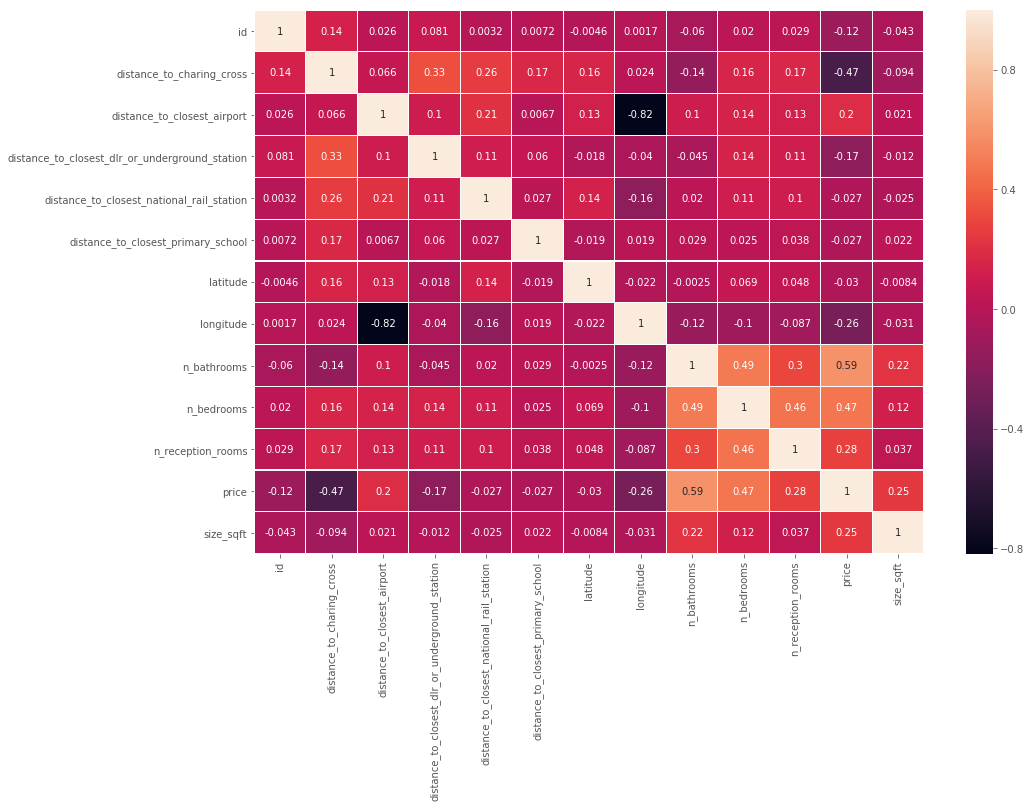

In [33]:
plot_corr(house_data)

A negative correlation exists between distance to closest airport and longitude. This might have effect on the prediction. One of the two features could be dropped

Plotting scatterplots between the numerical features and the target shows that there is no strong correlation among the variables

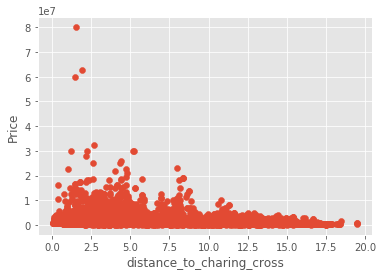

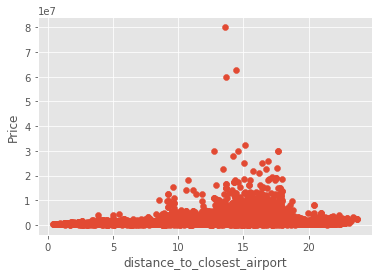

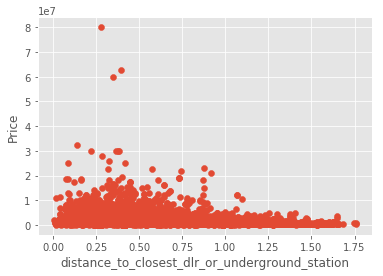

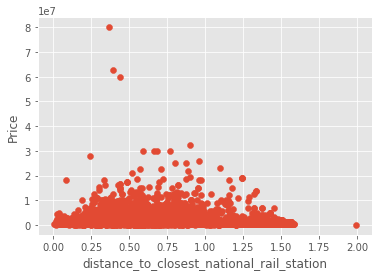

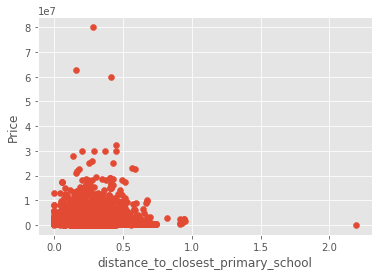

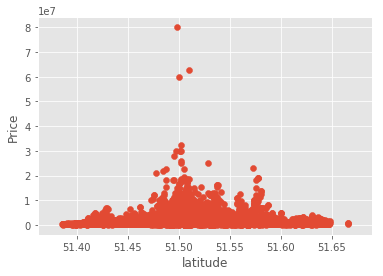

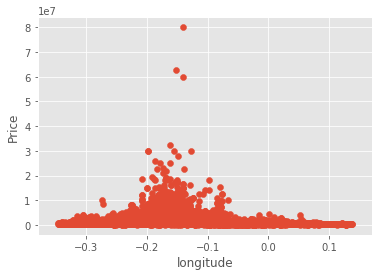

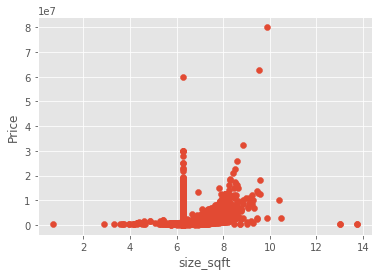

In [34]:
plot_scatter(house_data, num_var)

Visualize with log transformed price

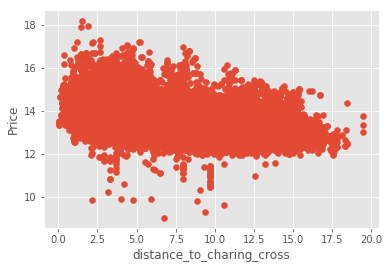

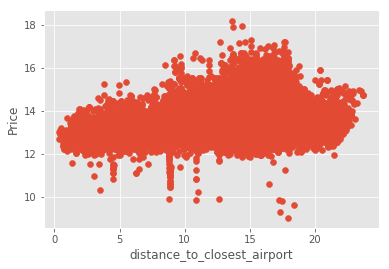

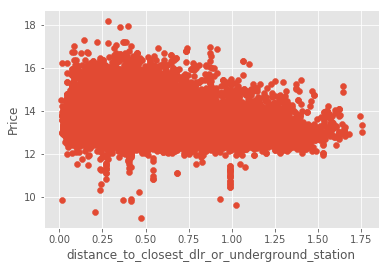

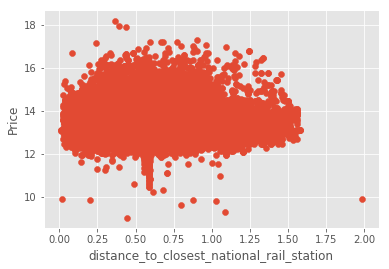

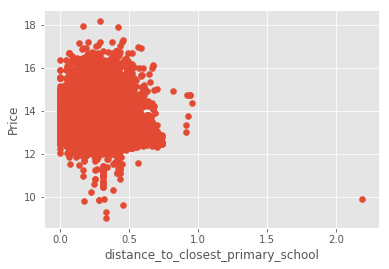

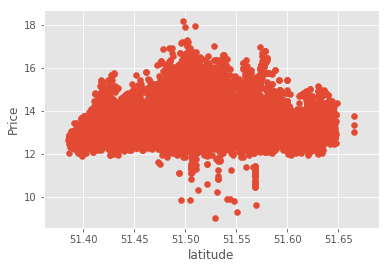

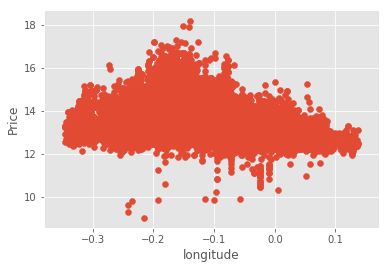

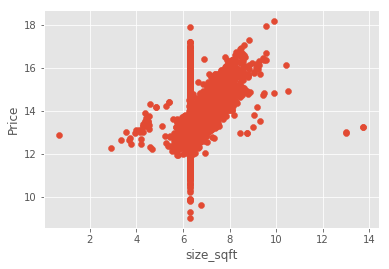

In [35]:
plot_scatter_log(house_data, num_var)

**Visualize target variable (price)**

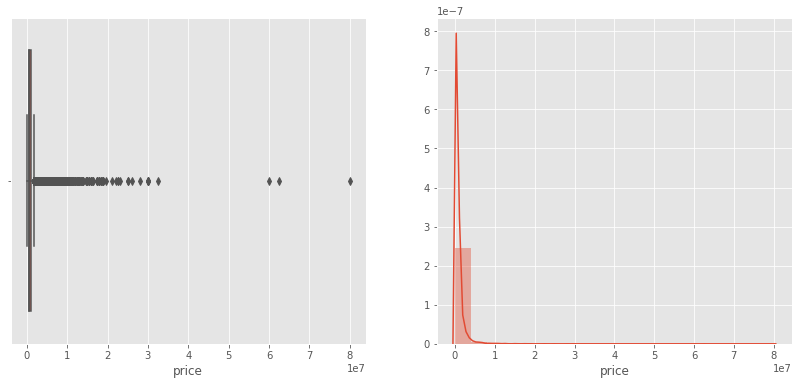

In [36]:
visualize_target(house_data, 'price')

The target variable seems to be highly skewed. This can be log transformed to approach normal distribution

**Add log transformed proce to the dataframe**

In [37]:
# Create a log transformed price column
house_data['LogPrice'] = np.log1p(house_data['price'])
house_data.head()

,id,condition,distance_to_charing_cross,distance_to_closest_airport,distance_to_closest_dlr_or_underground_station,distance_to_closest_national_rail_station,distance_to_closest_primary_school,latitude,longitude,n_bathrooms,n_bedrooms,n_reception_rooms,postcode,price,price_qualifier,property_type,size_sqft,status,tenure,LogPrice
0,893588,pre-owned,2.043523,10.497350,0.163245,0.301207,0.231467,51.510722,-0.095667,2.0,2.0,1.0,EC4,1050000,missing,flat,6.289716,for_sale,leasehold,13.864302
1,939056,pre-owned,2.305455,10.202792,0.408204,0.344609,0.341795,51.506942,-0.091646,4.0,3.0,1.0,SE1,3950000,missing,flat,6.289716,for_sale,leasehold,15.189226
2,1686433,pre-owned,7.224687,16.511607,0.309908,0.616327,0.218260,51.508411,-0.228859,1.0,3.0,1.0,W12,780000,missing,flat,6.289716,for_sale,freehold,13.567050
3,3407058,pre-owned,7.310310,5.648777,0.444710,0.882355,0.113631,51.491417,-0.022976,1.0,2.0,1.0,E14,460000,missing,flat,6.289716,for_sale,leasehold,13.038984
4,4077514,pre-owned,9.848651,9.726182,0.794085,0.541880,0.043947,51.574350,-0.030650,1.0,1.0,1.0,E17,265000,missing,flat,6.289716,for_sale,share_of_freehold,12.487489


**Plot the distribution of the log transformed price**

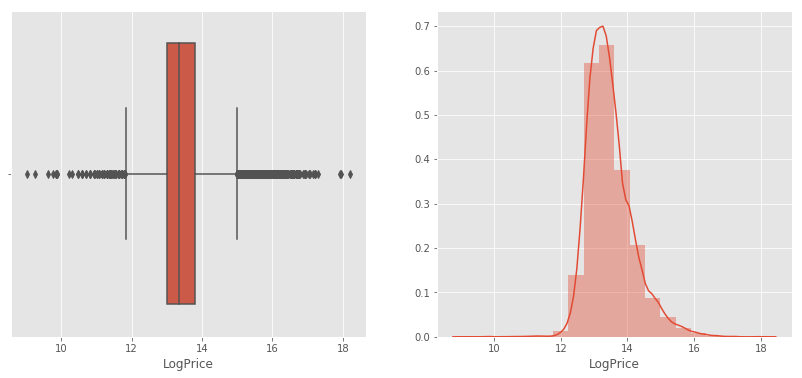

In [38]:
visualize_target(house_data, 'LogPrice')

After transformation, the target variable (price) is closer to the normal distribution

**Use IQR rule to identify potential outliers**

In [39]:
detect_outlier(house_data)

The upper and lower bounds for suspected outliers are 1812500.0 and -367500.0 


House price greater than £1,812,500 is considered an outlier

In [40]:
house_data2 = remove_oulier(house_data)

In [41]:
house_data.shape, house_data2.shape

((36213, 20), (32831, 20))

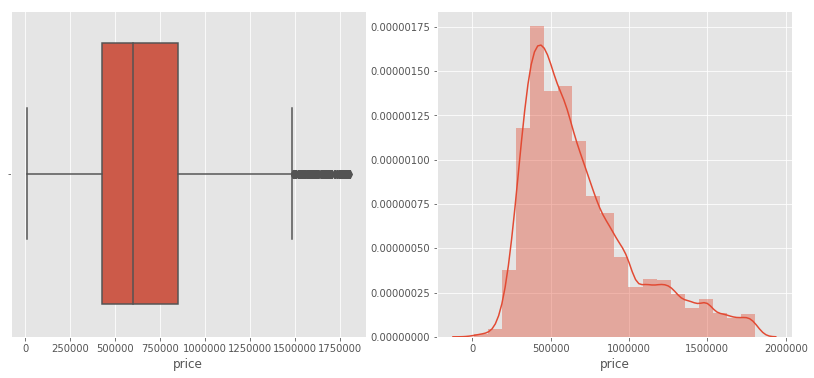

In [42]:
visualize_target(house_data2, 'price')

The distribution of the target(house price) now looks better after removing outliers

In [43]:
drop_column(house_data2, ['id', 'size_sqft', 'status', 'price_qualifier'])
house_data2.columns

C:\Users\Sakiru\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Index(['condition', 'distance_to_charing_cross', 'distance_to_closest_airport',
       'distance_to_closest_dlr_or_underground_station',
       'distance_to_closest_national_rail_station',
       'distance_to_closest_primary_school', 'latitude', 'longitude',
       'n_bathrooms', 'n_bedrooms', 'n_reception_rooms', 'postcode', 'price',
       'property_type', 'tenure', 'LogPrice'],
      dtype='object')

**Convert categorical features into numerical by one-hot-encoding**

In [45]:
house_data2 = encode_feature(house_data2)
house_data2.shape

(32831, 124)

In [46]:
check_missing_val(house_data2, house_data2.columns)

distance_to_charing_cross                         0.0
distance_to_closest_airport                       0.0
distance_to_closest_dlr_or_underground_station    0.0
distance_to_closest_national_rail_station         0.0
distance_to_closest_primary_school                0.0
latitude                                          0.0
longitude                                         0.0
n_bathrooms                                       0.0
n_bedrooms                                        0.0
n_reception_rooms                                 0.0
price                                             0.0
LogPrice                                          0.0
condition_pre-owned                               0.0
postcode_E10                                      0.0
postcode_E11                                      0.0
postcode_E12                                      0.0
postcode_E13                                      0.0
postcode_E14                                      0.0
postcode_E15                

## Build the model

In [47]:
#initialize model list and dicts
models = []
mean_mse = {}
cv_std = {}
res = {}

#define number of processes to run in parallel
num_procs = -1

#shared model paramaters
verbose_lvl = 0

In [ ]:
house_data.columns

In [48]:
y = house_data2['price']
#y_log = house_data2['LogPrice']
X = house_data2.drop(columns = ['price', 'LogPrice'])
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state = 42)

In [49]:
yl = house_data2['LogPrice']

In [50]:
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X, yl , test_size = 0.2, random_state = 42)

In [ ]:
models = []

In [51]:
#create models -- hyperparameter tuning already done by hand for each model
lr_std = make_pipeline(StandardScaler(), LinearRegression())
lr_std_pca = make_pipeline(StandardScaler(), PCA(n_components=0.95), LinearRegression())
rf = RandomForestRegressor(n_estimators=150, n_jobs=num_procs, max_depth=25, min_samples_split=60, \
                           max_features=30, verbose=verbose_lvl)
sgb= GradientBoostingRegressor(subsample=0.8, max_features= 0.8, n_estimators= 1000, max_depth=3, 
                               random_state=42)

gbm = GradientBoostingRegressor(n_estimators=150, max_depth=5, loss='ls', verbose=verbose_lvl)
                      
                      
xg= XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                     colsample_bynode=1, colsample_bytree=1, gamma=0,
                     importance_type='gain', learning_rate=0.25, max_delta_step=0,
                     max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
                     n_jobs=-1, nthread=None, objective='reg:squarederror',
                     random_state=42, reg_alpha=0.1, reg_lambda=1.0, scale_pos_weight=1,
                     seed=None, silent=None, subsample=1, verbosity=1)

lg= LGBMRegressor( max_depth= 9, num_leaves= 500, n_estimators= 1000, reg_alpha= 0.1, 
                     reg_lambda= 0.3, random_state=42, verbose= -1, n_jobs=-1,
                     metric= 'mae', learning_rate= 0.1, subsample= 0.8, 
                     bagging_fraction= 0.8, objective= 'regression_l2')

                      
models.extend([lr_std, lr_std_pca, rf, gbm, sgb, xg, lg]) #, rf, sgb, xg, lg]) #, lg])#, xg, rf, gbm])

#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    model_trainer(model, X_train, y_train, num_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

Beginning cross validation

Model:
 Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])
Average MSE:
 213259.8110255523
Standard deviation during CV:
 1535935529.134223

Model:
 Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])
Average MSE:
 229375.7870830092
Standard deviation during CV:
 2032118443.8811228

Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=30, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
  

## Hyperparameter tuning

In [52]:
def model_trainer_hp(model, X_train, y_train):
    model = model.fit(X_train, y_train)
    best_score = np.sqrt(-1*model.best_score_)
    print('best estimator:')
    print(model.best_estimator_)
    print(f'The best score is {best_score}')
    print('-'*70)

In [53]:
gs_models = []
gs_mean_mse = {}
gs_cv_std = {}
#define number of processes to run in parallel
num_procs = -1

In [54]:
cv = KFold(n_splits= 5, random_state= 42, shuffle= True )
rfc = RandomForestRegressor( n_jobs=num_procs, min_samples_split=60, max_features=30, verbose=verbose_lvl)
lgb = LGBMRegressor( num_leaves= 500, reg_alpha= 0.1,reg_lambda= 0.3, verbose= -1, n_jobs=-1, 
                     subsample= 0.8, bagging_fraction= 0.8, objective= 'regression_l2')
gbr = GradientBoostingRegressor()
sgbr = GradientBoostingRegressor(subsample=0.8, max_features= 0.8)

xgb= XGBRegressor( min_child_weight=1, n_jobs=-1)

gbr_hp = {"n_estimators": [250,400, 500, 650, 800, 1000],
      "max_depth": range(2,10),
      "min_samples_split": range(2,10),
              }
sgbr_hp = {"n_estimators": [250,400, 500, 650, 800, 1000],
      "max_depth": range(2,10),
      "min_samples_split": range(2,10),
              }

lgb_hp = {"n_estimators": [100, 250,400, 500, 1000],
           "max_depth": [5, 10, 15, 25, 30],
          "learning_rate": [0.1, 0.2, 0.3, 0.5]
        }

xgb_hp = {"n_estimators": [100, 250,400, 500, 1000],
           "max_depth": [5, 10, 15, 25, 30],
          "learning_rate": [0.1, 0.2, 0.3, 0.5]
        
        }

hp = {"n_estimators": [100, 250,400, 500, 1000],
      "max_depth": [5, 10, 15, 25, 30],
      #"min_samples_split": range(2,10),
      "bootstrap": [True, False]
              }
grid_search_rf = GridSearchCV(rfc, param_grid=hp, cv=cv, n_jobs= num_procs, scoring='neg_mean_squared_error')
grid_search_gbr = GridSearchCV(gbr, param_grid=gbr_hp, cv=cv, n_jobs= num_procs, scoring='neg_mean_squared_error')
grid_search_sgbr = GridSearchCV(sgbr, param_grid=sgbr_hp, cv=cv, n_jobs= num_procs, scoring='neg_mean_squared_error')
grid_search_lgb = GridSearchCV(lgb, param_grid=lgb_hp, cv=cv, n_jobs= num_procs, scoring='neg_mean_squared_error')
grid_search_xgb = GridSearchCV(xgb, param_grid=xgb_hp, cv=cv, n_jobs= num_procs, scoring='neg_mean_squared_error')
#grid_search_rf.fit(X_train, y_train)
#grid_search_lgb.fit(X_train, y_train)


In [55]:
grid_models = []

In [56]:
grid_models.extend([grid_search_rf, grid_search_gbr, grid_search_sgbr, grid_search_lgb, grid_search_xgb])
for model in grid_models:
    model_trainer_hp(model, X_train, y_train)

best estimator:
RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=30,
           max_features=30, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=60, min_weight_fraction_leaf=0.0,
           n_estimators=400, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
The best score is 178683.18319129167
----------------------------------------------------------------------
best estimator:
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             vali

C:\Users\Sakiru\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\Sakiru\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\Sakiru\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\Sakiru\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py

[18:08:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)
The best score is 157493.0501131917
----------------------------------------------------------------------


In [88]:
grid_models = []

In [89]:
grid_models.extend([grid_search_rf, grid_search_gbr, grid_search_sgbr, grid_search_lgb, grid_search_xgb])
for model in grid_models:
    model_trainer_hp(model, X_test, y_test)

best estimator:
RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=25,
           max_features=30, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=60, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
The best score is 197768.7202942656
----------------------------------------------------------------------
best estimator:
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=9, min_weight_fraction_leaf=0.0,
             n_estimators=800, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             valida

C:\Users\Sakiru\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:40:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)
The best score is 180668.64632830088
----------------------------------------------------------------------


After tuning the parameters, stochastic gradient boosting turns out to be the best model based on MSE

In [62]:
# Make predictions with the best model
best_model = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=0.8,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=8, min_weight_fraction_leaf=0.0,
             n_estimators=800, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=0.8, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
best_model.fit(X_train, y_train)
predictions = model.predict(X_test)

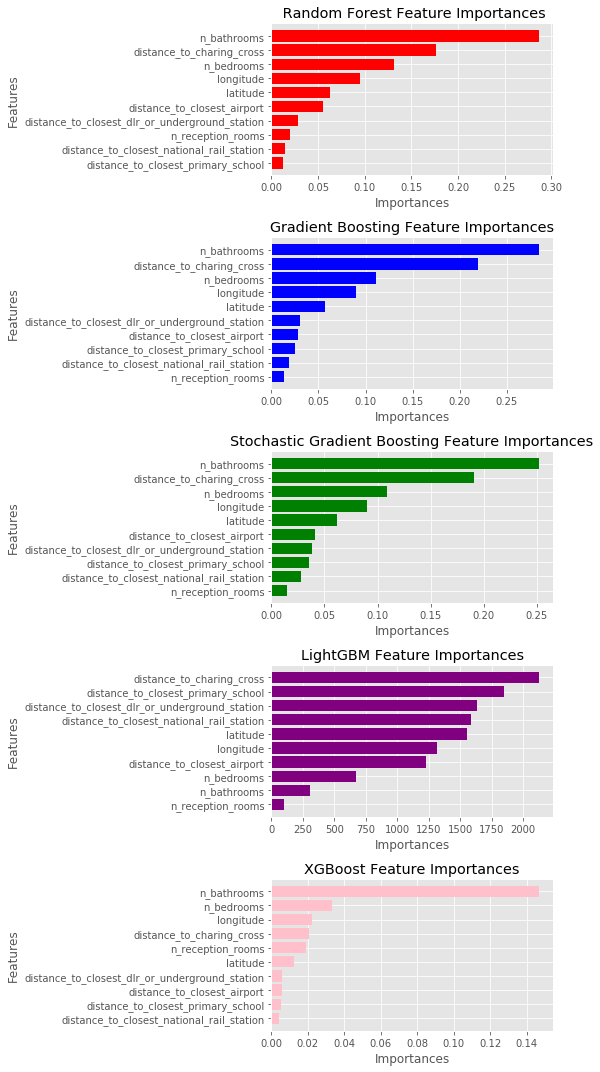

In [84]:
# plot feature importances
plot_feature_importance(grid_models)

The feature importances shows that number of bathrooms, distance to charing cross station and number of bedroom are the most important features for predicting house price in London. Number of bathrooms turns out to be the strongest predictor of house price.

In [91]:
#save final model
with open('house_price_best_model.pkl', 'wb') as final_model:
    pkl.dump(best_model, final_model)

**Summary**

London house price scrapped from zoopla website consisting of 36213 records and 20 columns were preprocessed and used to build a predictive model for predicting the price of a house in London. Machine learning models including linear regression, random forest regressor, gradient boosting regressor, stochastic gradient boosting regressor, LightGBM regressor and XGBoost regressor were used with Stochastic gradient boosting being the best model based on mean square error (MSE). Feature importances show that number of bathrooms, number of bedrooms and distance from Charing cross station are the most important features for predicting house price.  